In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import rpy2
%load_ext rpy2.ipython
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import utils
from matplotlib_venn import venn2, venn2_circles
mpl.rcParams['pdf.fonttype'] = 42

## Driver overlap

This notebook is intended to compare the significant predictions from CHASMplus. It also generates the supplementary table for the significant predictions from CHASMplus.

### Read in data

In [2]:
# read in significant mutations
df = utils.read_all_results()
var_id = df['Hugo_Symbol'] + '_' + df['HGVSp_Short']
df['Variant_ID'] = var_id

In [3]:
# read in mutation data
mut_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.maf')

### Overlap of pan-cancer analysis with cancer type-specific analysis

In [4]:
pancan_signif_list = df[df['PANCAN_flag']==1].Variant_ID.tolist()
cancer_type_signif_list = df[df['Any_cancer_type_flag']==1].Variant_ID.tolist()

(1369, 479, 2158)

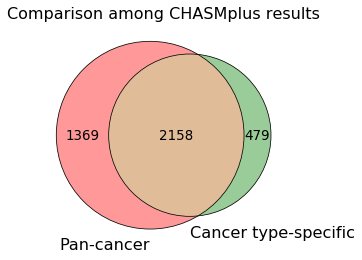

In [5]:
utils.venn_diagram(pancan_signif_list, cancer_type_signif_list,
                   'Pan-cancer', 'Cancer type-specific',
                   title='Comparison among CHASMplus results')

In [6]:
mut_df = pd.merge(mut_df, df[['Hugo_Symbol', 'HGVSp_Short', 'PANCAN_flag']], 
                  on=['Hugo_Symbol', 'HGVSp_Short'], how='left')
mut_df['Variant_ID'] = mut_df['Hugo_Symbol'] + '_' + mut_df['HGVSp_Short']

In [7]:
mut_df['Cancer_type_flag'] = 0
cancer_types = mut_df['CODE'].unique()
for c in cancer_types:
    # get the significant variants
    signif_vars = df[df[c+'_flag']==1].Variant_ID.tolist()
    
    # flag cancer type specific drivers
    is_cancer_type = mut_df['CODE']==c
    is_var = mut_df['Variant_ID'].isin(signif_vars)
    mut_df.loc[is_cancer_type & is_var, 'Cancer_type_flag'] = 1

In [8]:
# figure out variants found only by pan-cancer analysis
mut_df['PANCAN_specific_flag'] = 0
mut_df.loc[(mut_df['PANCAN_flag']==1) & (mut_df['Cancer_type_flag']==0), 'PANCAN_specific_flag'] = 1

In [9]:
mut_df.groupby('CODE')[['Cancer_type_flag', 'PANCAN_specific_flag']].sum()

,Cancer_type_flag,PANCAN_specific_flag
CODE,,
ACC,15,13
BLCA,881,135
BRCA,646,126
CESC,190,128
CHOL,13,15
COAD,392,98
DLBC,16,31
ESCA,136,83
GBM,288,53


### Overlap with results from The Cancer Genome Atlas

In [10]:
tcga_df = pd.read_table('CHASMplus/data/misc/TCGA_mutation_results.txt')

In [11]:
is_pop = tcga_df['Linear (functional) flag']
is_cancer = tcga_df['Linear (cancer-focused) flag']
is_struct = tcga_df['3D mutational hotspot flag']

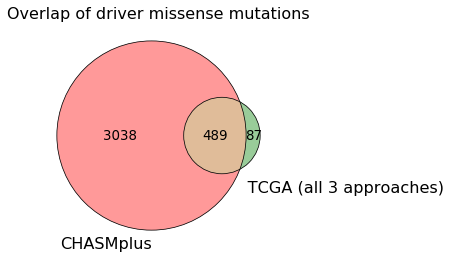

In [12]:
# all three methods
is_consensus = ((is_pop + is_cancer + is_struct)==3) #& (is_struct==1)
tcga_signif = (tcga_df[is_consensus]['gene'] + '_' + tcga_df[is_consensus]['protein_change']).tolist()

# plott venn diagram comparing CHASMplus to TCGA results
utils.venn_diagram(pancan_signif_list, tcga_signif,
                   'CHASMplus', '     TCGA (all 3 approaches)',
                   title='Overlap of driver missense mutations')
plt.savefig('CHASMplus/figures/figure_S3a.pdf')

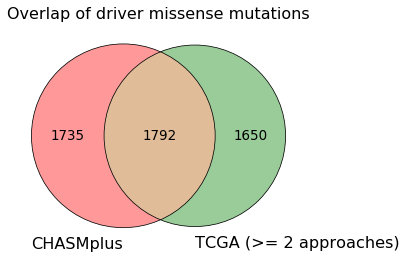

In [13]:
# at least two methods
is_consensus = ((is_pop + is_cancer + is_struct)>=2) #& (is_struct==1)
tcga_signif = (tcga_df[is_consensus]['gene'] + '_' + tcga_df[is_consensus]['protein_change']).tolist()

# plott venn diagram comparing CHASMplus to TCGA results
utils.venn_diagram(pancan_signif_list, tcga_signif,
                   'CHASMplus', 'TCGA (>= 2 approaches)',
                   title='Overlap of driver missense mutations')
plt.savefig('CHASMplus/figures/figure_S3b.pdf')

### Identify novel predictions

In [16]:
# read in oncokb
oncokb = utils.read_oncokb()

# label oncokb variants
oncokb_vars = oncokb['Hugo_Symbol'] + '_' + oncokb['HGVSp_Short']
df['OncoKB'] = 0
df.loc[df['Variant_ID'].isin(oncokb_vars), 'OncoKB'] = 1

# oncokb lists TP53 DNA-binding domain missense mutations as likely oncogenic
is_tp53 = df['Hugo_Symbol']=='TP53'
is_dna_bind_domain = (df['Protein_position'].astype(int)>=102) & (df['Protein_position'].astype(int)<=292)
df.loc[is_tp53 & is_dna_bind_domain, 'OncoKB'] = 1

# label variants also found in the official TCGA analysis
df['official TCGA analysis'] = 0
df.loc[df['Variant_ID'].isin(tcga_signif), 'official TCGA analysis'] = 1

In [17]:
# figure out what is found by us and not previously
is_pancan = df['PANCAN_flag']==1
is_any_ctype = df['Any_cancer_type_flag']==1
is_not_tcga = df['official TCGA analysis']==0
is_not_oncokb = df['OncoKB']==0

# Label novel mutations
df['Novel'] = 0
df.loc[(is_pancan | is_any_ctype) & is_not_tcga & is_not_oncokb, 'Novel']=1

### Prepare supplementary tables

To merge in information about the rarity of mutations, the "mutation" column is needed.

In [18]:
df['mutation'] = df['Hugo_Symbol'] + '_' + df['Transcript_ID'] + '_' + df['Protein_position']

First, create Supplementary Table 2 containing information on the pan-cancer predictions.

In [19]:
# read in rarity info for pancan
pancan_rare_df = pd.read_table('CHASMplus/data/rarity_analysis/PANCAN.txt')

# create supplementary table 4
supp_table2 = pd.merge(df[df['PANCAN_flag']==1], pancan_rare_df, on='mutation', how='left')
supp_table2 = supp_table2.sort_values(['CHASM2_genome'], ascending=False)
rename_dict = {
    'cancer type': 'cancer type with highest prevalence',
    'fraction of samples': 'fraction of samples mutated (highest cancer type)',
    'number of mutations': 'number of mutations (highest cancer type)',
    'category': 'frequency category (highest cancer type)',
    'Any_cancer_type_flag': 'Significant for any cancer type-specific analysis',
    'official TCGA analysis': 'Found in official TCGA analysis',
    'OncoKB': 'Found in OncoKB',
    'CHASM2_genome': 'gwCHASMplus score',
    'CHASM2_genome_pval': 'gwCHASMplus p-value',
    'PANCAN': 'gwCHASMplus q-value'
}
supp_table2 = supp_table2.rename(columns=rename_dict)

# save supplementary table 2
result_cols = ['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'gwCHASMplus score', 
               'gwCHASMplus p-value', 'gwCHASMplus q-value', 'cancer type with highest prevalence',
               'number of mutations (highest cancer type)',
               'fraction of samples mutated (highest cancer type)',
               'frequency category (highest cancer type)',
               'Significant for any cancer type-specific analysis', 
               'Found in official TCGA analysis', 'Found in OncoKB', 'Novel'
              ]
supp_table2[result_cols].to_csv('CHASMplus/results/table_S2.txt', sep='\t', index=False)

The next step is to create Supplementary Table 3, which contains the cancer type-specific results from CHASMplus.

In [20]:
column_order = [
    'Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'Protein_position',
    'gwCHASMplus q-value', 'cancer type',
    'number of mutations',
    'fraction of samples mutated',
    'frequency category',
    'Significant in CHASMplus pan-cancer analysis', 
    'Found in official TCGA analysis', 'Found in OncoKB', 'Novel'
]

ctypes = [c[:-5] for c in df.columns 
          if c.endswith('_flag') and 
          not c.startswith('PANCAN') and 
          not c.startswith('Any')]
df_list = []
for ctype in ctypes:
    tmp_rare_df = pd.read_table('CHASMplus/data/rarity_analysis/{0}.txt'.format(ctype))
    
    # formatting
    tmp_supp_table3 = pd.merge(df[df[ctype+'_flag']==1], tmp_rare_df, on='mutation', how='left')
    tmp_supp_table3 = tmp_supp_table3.sort_values(['CHASM2_genome'], ascending=False)
    rename_dict = {
        'fraction of samples': 'fraction of samples mutated',
        'number of mutations': 'number of mutations',
        'category': 'frequency category',
        'Any_cancer_type_flag': 'Significant for any cancer type-specific analysis',
        'official TCGA analysis': 'Found in official TCGA analysis',
        'OncoKB': 'Found in OncoKB',
        'CHASM2_genome': 'gwCHASMplus score',
        'CHASM2_genome_pval': 'gwCHASMplus p-value',
        ctype: 'gwCHASMplus q-value',
        'PANCAN_flag': 'Significant in CHASMplus pan-cancer analysis'
    }
    tmp_supp_table3 = tmp_supp_table3.rename(columns=rename_dict)
    
    # add to df list
    df_list.append(tmp_supp_table3[column_order])
    
# save results
supp_table3 = pd.concat(df_list)
supp_table3.to_csv('CHASMplus/results/table_S3.txt', sep='\t', index=False)

Prepare supplementary table for melanoma.

In [21]:
skcm = utils.read_result('SKCM')
skcm['SKCM_flag'] = (skcm['SKCM']<=0.01).astype(int)
skcm['mutation'] = skcm['Hugo_Symbol'] + '_' + skcm['Transcript_ID'] + '_' + skcm['Protein_position']

# read in rarity info for pancan
skcm_rare_df = pd.read_table('CHASMplus/data/rarity_analysis/SKCM.txt')

# create supplementary table 7
supp_table7 = pd.merge(skcm[skcm['SKCM_flag']==1], skcm_rare_df, on='mutation', how='left')
supp_table7 = supp_table7.sort_values(['CHASM2_genome'], ascending=False)
rename_dict = {
    'SKCM': 'gwCHASMplus q-value',
    'cancer type': 'cancer type',
    'fraction of samples': 'fraction of samples mutated',
    'number of mutations': 'number of mutations',
    'category': 'frequency category',
    'Any_cancer_type_flag': 'Significant for any cancer type-specific analysis',
    'official TCGA analysis': 'Found in official TCGA analysis',
    'OncoKB': 'Found in OncoKB',
    'CHASM2_genome': 'gwCHASMplus score',
    'CHASM2_genome_pval': 'gwCHASMplus p-value',
    'PANCAN': 'gwCHASMplus q-value'
}
supp_table7 = supp_table7.rename(columns=rename_dict)

result_cols = ['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'gwCHASMplus score', 
               'gwCHASMplus p-value', 'gwCHASMplus q-value', 'cancer type',
               'number of mutations',
               'fraction of samples mutated',
               'frequency category',
              ]
supp_table7[result_cols].to_csv('CHASMplus/results/table_S7.txt', sep='\t', index=False)

### Scratch

In [38]:
max_ixs = supp_table5.reset_index().groupby(['cancer type', 'Hugo_Symbol'])['fraction of samples mutated'].idxmax()
output_cols = ['cancer type', 'Hugo_Symbol', 'HGVSp_Short', 'fraction of samples mutated', 'frequency category']
#supp_table5.loc[max_ixs, output_cols]
#supp_table5.groupby(['cancer type', 'Hugo_Symbol']).idxmax()
#supp_table5[supp_table5['Hugo_Symbol']=='TP53']
#supp_table5.loc[max_ixs, output_cols].sort_values('cancer type')
supp_table5.iloc[max_ixs.values][output_cols].to_csv('/Users/ctokheim/Downloads/chasmplus_max_freq.txt', sep='\t', index=False)

In [77]:
dup_cols = ['cancer type', 'Hugo_Symbol', 'Protein_position']
no_dup_df = supp_table5.drop_duplicates(subset=dup_cols)
overall_frac = no_dup_df.groupby(dup_cols[:2])['fraction of samples mutated'].sum().reset_index()
num_muts_by_cat = no_dup_df.groupby(['cancer type', 'Hugo_Symbol', 'frequency category'])['number of mutations'].sum()
tot_muts_df = num_muts_by_cat.sum(level=[0,1]).reset_index().rename(columns={'number of mutations': 'total mutations'})
num_muts_df = num_muts_by_cat.reset_index()
merged_df = pd.merge(num_muts_df, tot_muts_df, on=['cancer type', 'Hugo_Symbol'], how='left')
merged_df = pd.merge(merged_df, overall_frac, on=['cancer type', 'Hugo_Symbol'], how='left')
merged_df['fraction of frequency category'] = merged_df['number of mutations'] / merged_df['total mutations']
formatted_df = pd.pivot_table(merged_df, 
                              index=['cancer type', 'Hugo_Symbol', 'fraction of samples mutated'], 
                              values='fraction of frequency category', 
                              columns='frequency category').fillna(0.0).reset_index()
formatted_df.to_csv('/Users/ctokheim/Downloads/chasmplus_freq.txt', sep='\t', index=False)